## Final Project Submission

Please fill out:
* Student name: Collin Loo
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: James M Irving, Ph.D.
* Blog post URL: 

## Project Roadmap

#### Objectives:


#### Business Case:


#### Project Approach


***
## Obtain Data

In [2]:
### Import Libraries
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from my_func import *

%matplotlib inline

In [3]:
df = pd.read_csv('data\zillow_data.csv')
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [4]:
# import Zillow Observed Rent Index (ZORI).  The csv also contains manually computed 
# capital gain over a period of five years, price to rent ratio, cash on cash,
# ROI and rent index stddev information.
df_zori = pd.read_csv('data/zori.csv')

# preview data
df_zori.head()

RegionName  cap_gain_5yrs  price_to_rent   COC   ROI  RentalSTD
0       60657           0.26             50 -0.10  0.08      56.00
1       75070           0.53             18  0.04  0.24      78.09
2       77494           0.28             19  0.03  0.22      42.19
3       60614           0.26             64 -0.11  0.07      56.00
4       79936           0.07              9  0.23  0.45       6.96

In [5]:
df_zori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14572 entries, 0 to 14571
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RegionName     14572 non-null  int64  
 1   cap_gain_5yrs  14572 non-null  float64
 2   price_to_rent  14572 non-null  int64  
 3   COC            14572 non-null  float64
 4   ROI            14572 non-null  float64
 5   RentalSTD      14572 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 683.2 KB


In [6]:
# combine the two dataframes
df_comb = pd.merge(df, df_zori, on='RegionName')

# preview data
df_comb.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-12  2018-01  2018-02  \
0         1  334200.0  335400.0  336500.0  ...  1018700  1024400  1030700   
1         2  235700.0  236900.0  236700.0  ...   316600   318100   319600   
2         3  210400.0  212200.0  212200.0  ...   321200   321200   323000   
3         4  498100.0  500900.0  503100.0  ...  1299000  1302700  1306400   
4         5   77300.0   77300.0   77300.0  ...   120300   120300   120500   

   2018-03  2018-04  cap_gain_5yrs  price_to_rent   COC   ROI  RentalSTD  
0  1033800  1030600           0.26             50 -0.10  0.08      56.00  
1   321100   321800           0.53             18  0.04  0.24      78.09  
2   326900   329900           0.28             19  0.03  0.22      42.19  
3  1308500  1307000           0.26             64 -0.11  0.07      56.00  
4   121000   121500           0.07              9  0.23  0.45       6.96  

[5 rows x 277 columns]

***
## Preprocess Data

In [7]:
# examine columns 
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14572 entries, 0 to 14571
Columns: 277 entries, RegionID to RentalSTD
dtypes: float64(223), int64(50), object(4)
memory usage: 30.9+ MB


### Subset Data Based on Investment Strategies

**Subset the data based on the following assumption:**
1. Properties must have a price to rent ration between 12 - 20 as this is a good indicator
   for people to choose renting over owning.
2. Capital gain over the 5-years period should be greater than 3.5%.  National average is about 3.9%.
3. Cash on cash return rate should be greater than 8%.
4. Return on investment should be greater than 10%.
5. Rental index standard deviation should be within the 30% to 60% quantile to minimize
   risk and volatility.

In [8]:
# filter data
p_to_r = df_comb[(df_comb['price_to_rent'] > 11) & (df_comb['price_to_rent'] < 20)]
cap_gain = p_to_r[p_to_r['cap_gain_5yrs'] > 0.035]
c_on_c = cap_gain[cap_gain['COC'] > 0.08]
roi = c_on_c[c_on_c['ROI'] > 0.10]
q_low, q_high = roi['RentalSTD'].quantile([.3, .6])
df_filtered = roi[(roi['RentalSTD'] >= q_low) & (roi['RentalSTD'] <= q_high)]

# preview filtered data
df_filtered.head()

RegionID  RegionName           City State        Metro CountyName  \
18     92593       78660   Pflugerville    TX       Austin     Travis   
23     92045       77584       Pearland    TX      Houston   Brazoria   
31     92271       78130  New Braunfels    TX  San Antonio      Comal   
37     91922       77429        Cypress    TX      Houston     Harris   
44     91926       77433        Cypress    TX      Houston     Harris   

    SizeRank   1996-04   1996-05   1996-06  ...  2017-12  2018-01  2018-02  \
18        19  138900.0  138600.0  138400.0  ...   239400   240000   241000   
23        24  138500.0  138700.0  139200.0  ...   251400   251900   253200   
31        32  123900.0  123900.0  123800.0  ...   215500   216000   217200   
37        39  149600.0  148800.0  148100.0  ...   241300   241700   242200   
44        46  147300.0  147600.0  148100.0  ...   249200   249800   250200   

    2018-03  2018-04  cap_gain_5yrs  price_to_rent   COC   ROI  RentalSTD  
18   242200   242800           0.43             14  0.11  0.31      59.30  
23   255100   256500           0.37             15  0.09  0.29      42.19  
31   219500   221100           0.38             15  0.09  0.29      51.40  
37   243200   243800           0.38             14  0.10  0.30      42.19  
44   251500   252600           0.31             14  0.09  0.29      42.19  

[5 rows x 277 columns]

**To diversify our investment profile, we will pick the top 5 zip codes based on:**
1. Property showing highest ROI.
2. One zip code per State.

In [9]:
# get list of States
states = list(set(df_filtered.State))
df_top_states = pd.DataFrame()

# select top zip code from each state
for state in states:
    temp = df_filtered[(df_filtered['State'] == state)]
    df_top_states = df_top_states.append(temp[temp['ROI'] == temp['ROI'].max()])
    
# select the top 5 zip codes
df_top_zc = df_top_states.sort_values(by=['ROI', 'cap_gain_5yrs'], ascending=False)[0:5]

# preview dataframe
df_top_zc.head()

RegionID  RegionName            City State       Metro      CountyName  \
3690      79075       48220        Ferndale    MI     Detroit         Oakland   
11060     66581       20722       Brentwood    MD  Washington  Prince Georges   
6618      66591       20737  East Riverdale    MD  Washington  Prince Georges   
7148      78895       48001         Algonac    MI     Detroit     Saint Clair   
10679     78931       48049    North Street    MI     Detroit     Saint Clair   

       SizeRank   1996-04   1996-05   1996-06  ...  2017-12  2018-01  2018-02  \
3690       3703   61000.0   61600.0   62300.0  ...   156800   158600   160700   
11060     11135   99300.0   98800.0   98300.0  ...   276100   277300   278900   
6618       6648  115500.0  115400.0  115300.0  ...   276200   276800   277900   
7148       7180   85100.0   86000.0   86800.0  ...   147600   146700   149100   
10679     10748   95100.0   95900.0   96600.0  ...   159600   157500   157900   

       2018-03  2018-04  cap_gain_5yrs  price_to_rent   COC   ROI  RentalSTD  
3690    162500   163500           1.18             12  0.16  0.37      44.05  
11060   281700   284100           0.94             12  0.16  0.37      43.29  
6618    280500   284000           0.85             12  0.16  0.37      43.29  
7148    155800   162100           0.81             12  0.16  0.37      44.05  
10679   160900   163100           0.75             12  0.16  0.37      44.05  

[5 rows x 277 columns]

### Format Data for Time Series

In [10]:
# define non-date columns
id_vars = ['RegionID', 'RegionName', 'City','State', 'Metro', 'CountyName',
            'SizeRank', 'cap_gain_5yrs', 'price_to_rent', 'COC', 'ROI', 'RentalSTD']

df_ts = pd.melt(df_top_zc, id_vars=id_vars, var_name='time')
df_ts['time'] = pd.to_datetime(df_ts['time'], infer_datetime_format=True)
# preview dataframe
df_ts.head()

RegionID  RegionName            City State       Metro      CountyName  \
0     79075       48220        Ferndale    MI     Detroit         Oakland   
1     66581       20722       Brentwood    MD  Washington  Prince Georges   
2     66591       20737  East Riverdale    MD  Washington  Prince Georges   
3     78895       48001         Algonac    MI     Detroit     Saint Clair   
4     78931       48049    North Street    MI     Detroit     Saint Clair   

   SizeRank  cap_gain_5yrs  price_to_rent   COC   ROI  RentalSTD       time  \
0      3703           1.18             12  0.16  0.37      44.05 1996-04-01   
1     11135           0.94             12  0.16  0.37      43.29 1996-04-01   
2      6648           0.85             12  0.16  0.37      43.29 1996-04-01   
3      7180           0.81             12  0.16  0.37      44.05 1996-04-01   
4     10748           0.75             12  0.16  0.37      44.05 1996-04-01   

      value  
0   61000.0  
1   99300.0  
2  115500.0  
3   85100.0  
4   95100.0

In [11]:
# put cities to list
cities = df_ts.City.unique()

# preview list
cities

array(['Ferndale', 'Brentwood', 'East Riverdale', 'Algonac',
       'North Street'], dtype=object)

***
## Explore Data

### General Plot of Home Values

In [12]:
plot_ts(df_ts)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The declining trend started around the beginning of 2007 can be attributed to the 2008 real estate bubble burst.
        <li>Durham, NC seems to be immune from the crisis.  One of the reason is that, according to the inflation-adjusted home-price appreciation from 1998-2006, North Carolina is among the lowest States in term of home price appreciation, less than 20%, compares to other States where the home-price appreciation exceeded 80%.</li>
        <li>We may consider excluding data prior to 2009 for our analysis because of this structural break in the time series.</li>
    </ul>
</div>

In [13]:
# subset data after the 2008 crisis
df_ts_af_crisis = df_ts[df_ts.time > '2008-12-01']
plot_ts(df_ts_af_crisis)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>It appears there is a recovery period of about two to three years before we see an upward trend in home values.</li>
        <li>Brentwood out paced the rest of the cities in term of home values appreciation.</li>
        <li>Data exhibits a linear upward trend, thus detrending will be required prior to modeling.</li>
        <li>No obvious seasonality detected.</li>
    </ul>
</div>

### Home Values Data Distribution

In [14]:
px_displot(df_ts_af_crisis)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

In [15]:
px_displot(df_ts_af_crisis, stdized=True)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

### Box and Whisker plot

In [16]:
# plot the boxplot for the five cities
for city in cities:
    tmp = get_data_by_city(df_ts_af_crisis, city)
    
    # Use pandas grouper to group values using annual frequency
    tmp_yr = tmp['2009':'2017'].groupby(pd.Grouper(freq ='A'))
    tmp_annual = pd.DataFrame()
    
    for yr, group in tmp_yr:
        tmp_annual[yr.year] = group.values.ravel()

    fig = go.Figure()
    for year in tmp_annual.columns:
        fig.add_trace(go.Box(y=tmp_annual[year], name=year))
        fig.update_layout(title=f'Annual Home Values -{city}',
                          xaxis_title="Year",
                          yaxis_title="Value"
                         )
        fig.update_xaxes(showline=True, linewidth=1, linecolor='gray', mirror=True)
        fig.update_yaxes(showline=True, linewidth=1, linecolor='gray', mirror=True)
    fig.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>No major outliers detected in the five cities.</li>
        <li>The average home values in the subsequent years after 2012, jump up significantly.</li>
        <li>Means of home values dependent on time.</li>
    </ul>
</div>

### Stationarity Check

In [17]:
stationarity_diff_chk(df_ts_af_crisis, cities, periods=1, plot=True, doubdiff=False)

Test Statistic   p-value  #Lags Used  \
Ferndale, Differencing             -2.244599  0.190458           5   
Brentwood, Differencing            -3.175083  0.021473           8   
East Riverdale, Differencing       -2.405478  0.140196           9   
Algonac, Differencing              -3.389773  0.011313           9   
North Street, Differencing         -2.273864  0.180536          12   

                              # of Observations Used  p<.05  Stationary?  
Ferndale, Differencing                           105  False        False  
Brentwood, Differencing                          102   True         True  
East Riverdale, Differencing                     101  False        False  
Algonac, Differencing                            101   True         True  
North Street, Differencing                        98  False        False

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Performing differencing on the top 5 cities only resulted in 3 of them meeting the stationary assumption.</li>
    </ul>
</div>

In [18]:
# perform 2nd order differencing on Ferndale and Durham
stationarity_diff_chk(df_ts_af_crisis, cities=['Ferndale', 'East Riverdale', 'North Street'],
                      periods=1, plot=True, doubdiff=True)

Test Statistic       p-value  #Lags Used  \
Ferndale, Differencing             -6.682885  4.297767e-09           4   
East Riverdale, Differencing       -4.185763  6.964343e-04          13   
North Street, Differencing         -5.777477  5.218644e-07          13   

                              # of Observations Used  p<.05  Stationary?  
Ferndale, Differencing                           105   True         True  
East Riverdale, Differencing                      96   True         True  
North Street, Differencing                        96   True         True

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>the 2nd order differencing cities solved the stationarity issues for Ferndale, Newark and Ringgold.</li>
    </ul>
</div>

### Autocorrelation

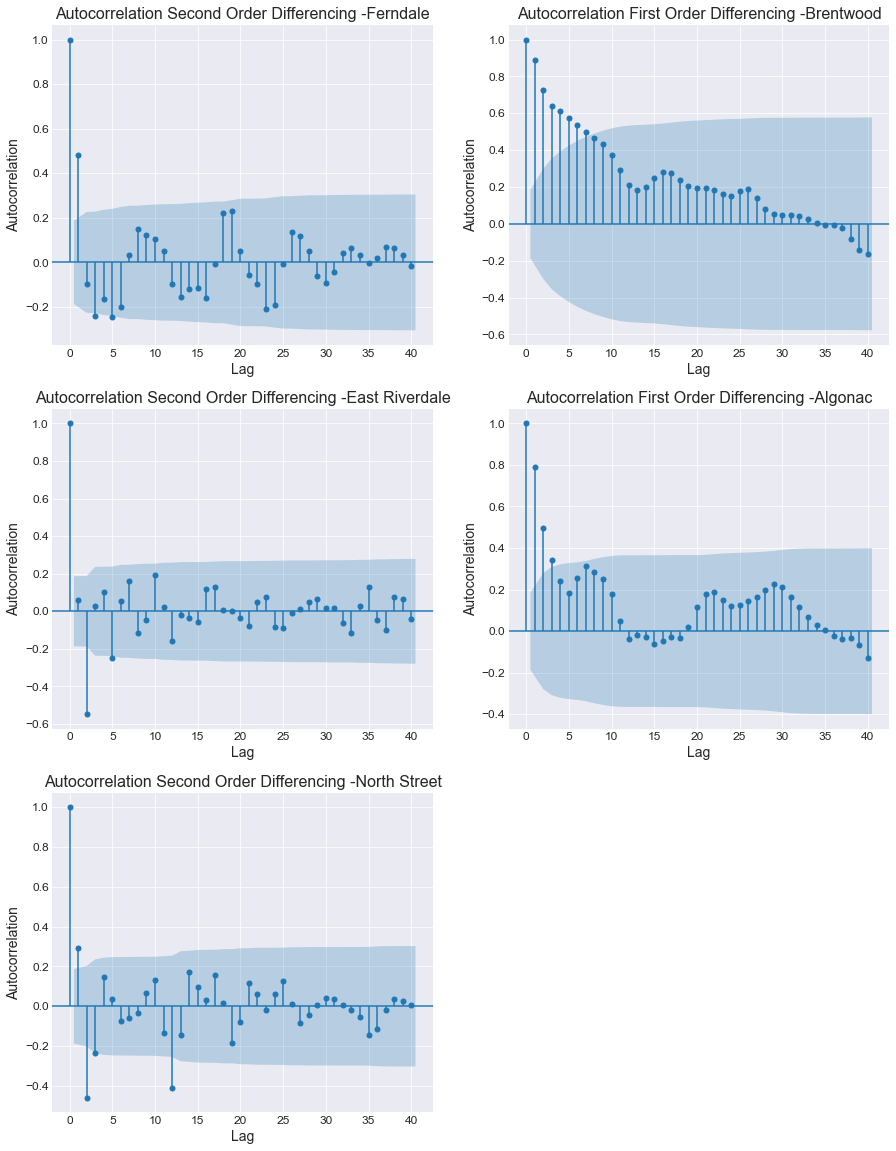

In [19]:
# plot the autocorrelation by city
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

with plt.style.context('seaborn-darkgrid'):
    plt.figure(figsize=(15, 20))
    plot_number = 1
    for city in cities:
        if city in ['Brentwood', 'Algonac']:
            tmp = get_data_by_city(df_ts_af_crisis, city)
            axn = plt.subplot(3, 2, plot_number)
            plot_acf(tmp.diff().dropna(), ax=axn, lags=40)
            plt.title(f'Autocorrelation First Order Differencing -{city}', size=16)
        elif city in ['Ferndale', 'East Riverdale', 'North Street']:
            tmp = get_data_by_city(df_ts_af_crisis, city)
            axn = plt.subplot(3, 2, plot_number)
            plot_acf(tmp.diff().diff().dropna(), ax=axn, lags=40)
            plt.title(f'Autocorrelation Second Order Differencing -{city}', size=16)
        plot_number = plot_number + 1
#         plt.title(f'Autocorrelation -{city}', size=16)
        plt.xlabel('Lag', size=14)
        plt.ylabel('Autocorrelation', size=14)
        plt.xticks(size=12)
        plt.yticks(size=12)
    plt.show()
    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>All five cities show similar pattern where the autocorrelation is high initially and then a slow decay after a lag of 8. This indicates that the series are of type called random walk series.  </li>
        <li>No seasonality detected from the 5 autocorrelation plots.</li>
    </ul>
</div>

### Partial Autocorrelation Plot

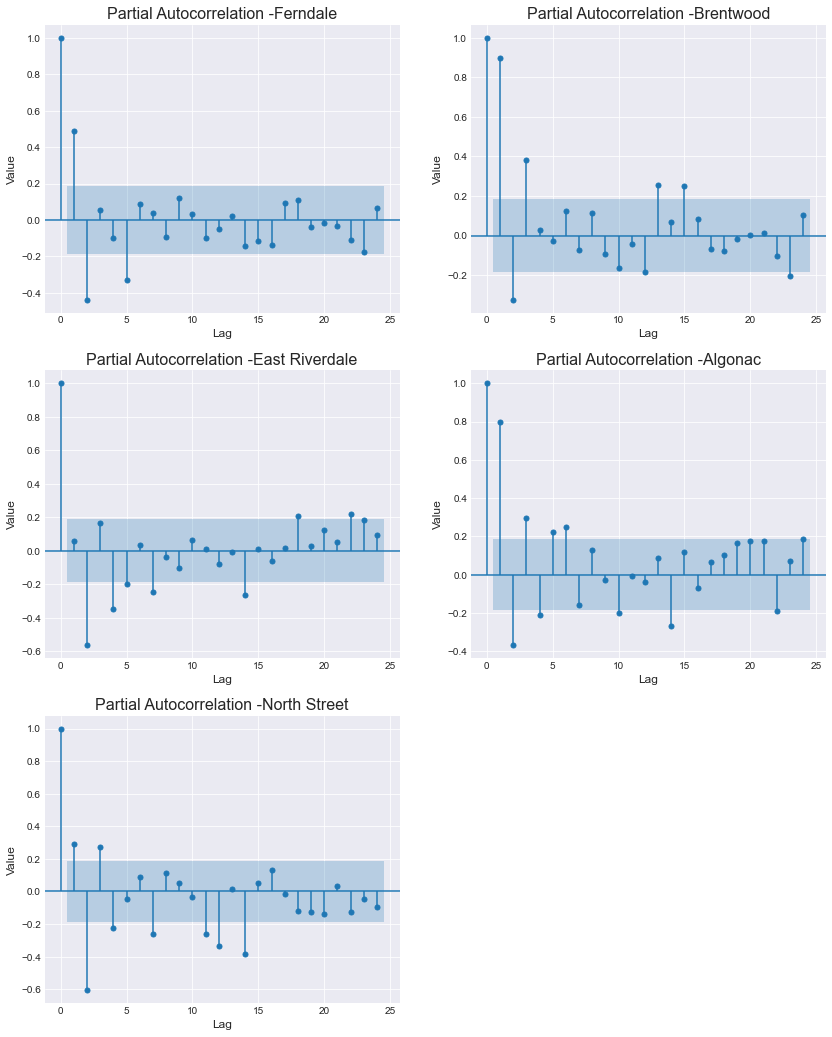

In [20]:
# plot partial autocorrelation by city
with plt.style.context('seaborn-darkgrid'):
    plt.figure(figsize=(14, 18))
    plot_number = 1
    for city in cities:
        if city in ['Brentwood', 'Algonac']:
            tmp = get_data_by_city(df_ts_af_crisis, city)
            axn = plt.subplot(3, 2, plot_number)
            plot_pacf(tmp.diff().dropna(), ax=axn, lags=24)
            plt.title(f'Autocorrelation First Order Differencing -{city}', size=16)
        elif city in ['Ferndale', 'East Riverdale', 'North Street']:
            tmp = get_data_by_city(df_ts_af_crisis, city)
            axn = plt.subplot(3, 2, plot_number)
            plot_pacf(tmp.diff().diff().dropna(), ax=axn, lags=24)
            plt.title(f'Autocorrelation Second Order Differencing -{city}', size=16)
        plot_number = plot_number + 1
        plt.title(f'Partial Autocorrelation -{city}', size=16)
        plt.xlabel('Lag', size=12)
        plt.ylabel('Value', size=12)
        plt.xticks(size=10)
        plt.yticks(size=10)
    plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Again all five cities show a random walk time series as the partial autocorrelation is only very hight for one-period lags.</li>
    </ul>
</div>

### Decompose Trend

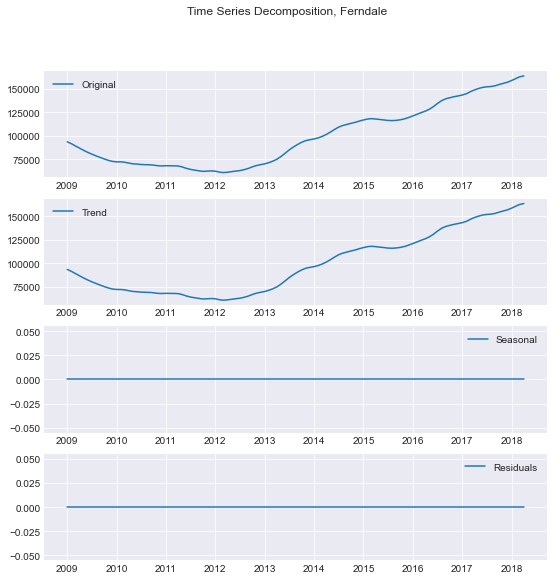

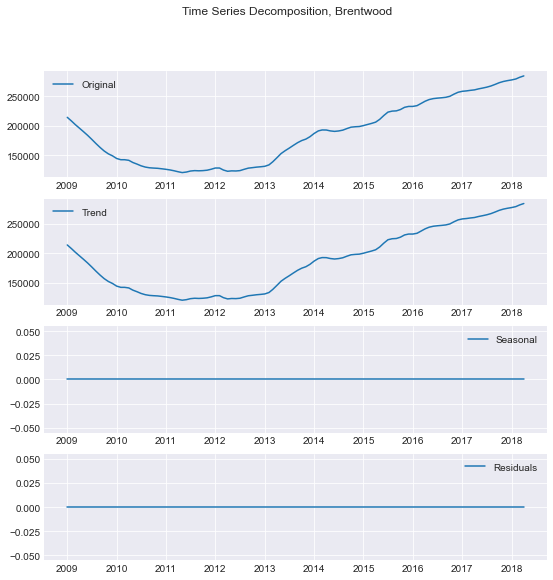

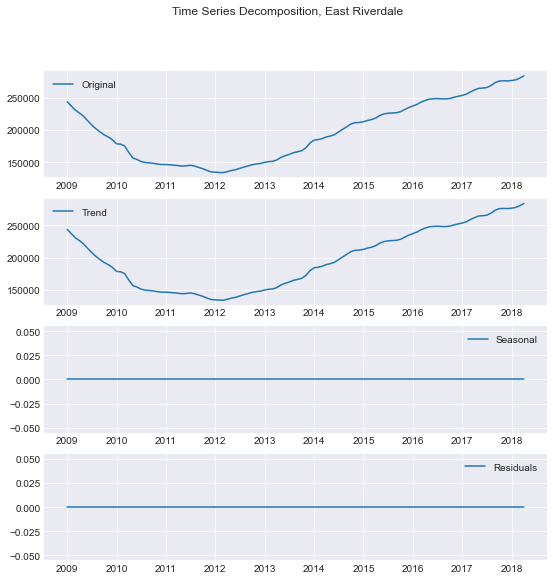

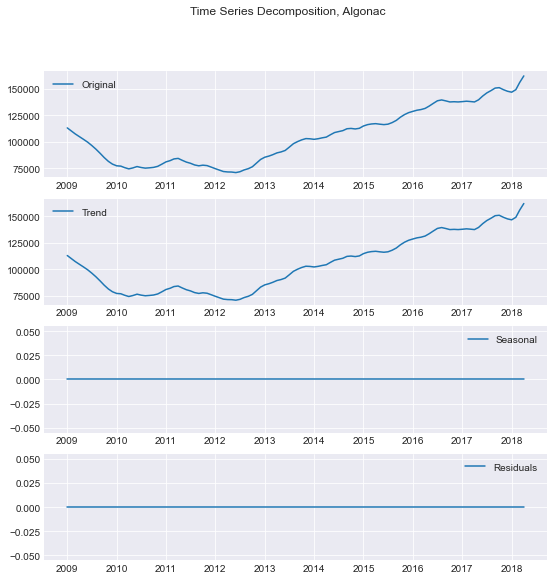

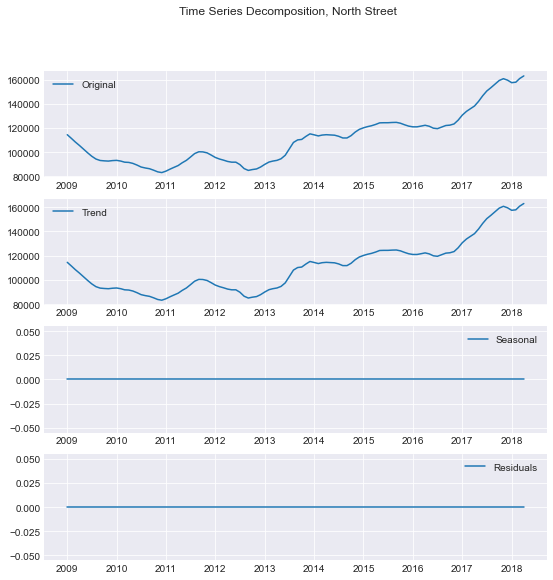

In [21]:
# Plot trend decomposition
for city in cities:
    # Import and apply seasonal_decompose()
    decomposition = seasonal_decompose(get_data_by_city(df_ts_af_crisis, city),\
                                       model='additive', period=1)

    # Gather the trend, seasonality, and residuals 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    with plt.style.context('seaborn-darkgrid'):
        fig, axs = plt.subplots(4, 1,figsize=(9, 9))
        axs[0].plot(get_data_by_city(df_ts_af_crisis, city), label='Original')
        axs[0].legend(fancybox=True)
        axs[1].plot(trend, label='Trend')
        axs[1].legend(fancybox=True)
        axs[2].plot(seasonal, label='Seasonal')
        axs[2].legend(fancybox=True)
        axs[3].plot(residual, label='Residuals')
        axs[3].legend(fancybox=True)
        fig.suptitle(f'Time Series Decomposition, {city}')
        plt.show()

***
## ARIMA Model

### Define Train and Test Data Set Cutoff

In [22]:
# separate data into train and validation set
df_train = df_ts_af_crisis[(df_ts_af_crisis.time > '2008-12-01')
                           & (df_ts_af_crisis.time < '2017-01-01')]
df_val = df_ts_af_crisis[(df_ts_af_crisis.time > '2016-12-01')]

# verify no data overlap
display(df_train.tail(3))
display(df_val.head(3))

# check train data set percent allocated
print(f'\n*** Percent allocated to train set:\
      {round(len(df_train)/len(df_ts_af_crisis), 2)} ***')

RegionID  RegionName            City State       Metro      CountyName  \
1242     66591       20737  East Riverdale    MD  Washington  Prince Georges   
1243     78895       48001         Algonac    MI     Detroit     Saint Clair   
1244     78931       48049    North Street    MI     Detroit     Saint Clair   

      SizeRank  cap_gain_5yrs  price_to_rent   COC   ROI  RentalSTD  \
1242      6648           0.85             12  0.16  0.37      43.29   
1243      7180           0.81             12  0.16  0.37      44.05   
1244     10748           0.75             12  0.16  0.37      44.05   

           time     value  
1242 2016-12-01  252300.0  
1243 2016-12-01  137500.0  
1244 2016-12-01  126500.0

RegionID  RegionName            City State       Metro      CountyName  \
1245     79075       48220        Ferndale    MI     Detroit         Oakland   
1246     66581       20722       Brentwood    MD  Washington  Prince Georges   
1247     66591       20737  East Riverdale    MD  Washington  Prince Georges   

      SizeRank  cap_gain_5yrs  price_to_rent   COC   ROI  RentalSTD  \
1245      3703           1.18             12  0.16  0.37      44.05   
1246     11135           0.94             12  0.16  0.37      43.29   
1247      6648           0.85             12  0.16  0.37      43.29   

           time     value  
1245 2017-01-01  143200.0  
1246 2017-01-01  258100.0  
1247 2017-01-01  253700.0


*** Percent allocated to train set:      0.86 ***


### Parameter Selection for ARIMA

### range of 2, enf=False

In [75]:
# define p,d & q parameters
p = d = q = range(0,2)

# generate different combination of p,d,q
pdq = list(itertools.product(p,d,q))
# display(pdq)

In [76]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    try:
        tmp = get_data_by_city(df_train, 'Ferndale')
        mod = sm.tsa.statespace.SARIMAX(tmp.value,
                                        order=comb,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        output = mod.fit()
        ans.append([comb, output.aic])
#         print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
    except:
        continue

In [77]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq    (1, 1, 1)
aic      1364.69
Name: 7, dtype: object

In [78]:
# Plug the optimal parameter values into a new SARIMAX model
tmp = get_data_by_city(df_train, 'Ferndale')
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(tmp.value, 
                                        order=(1, 1, 1), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9332      0.029     31.689      0.000       0.875       0.991
ma.L1          0.4954      0.056      8.786      0.000       0.385       0.606
sigma2      1.077e+05   1.95e+04      5.529      0.000    6.95e+04    1.46e+05


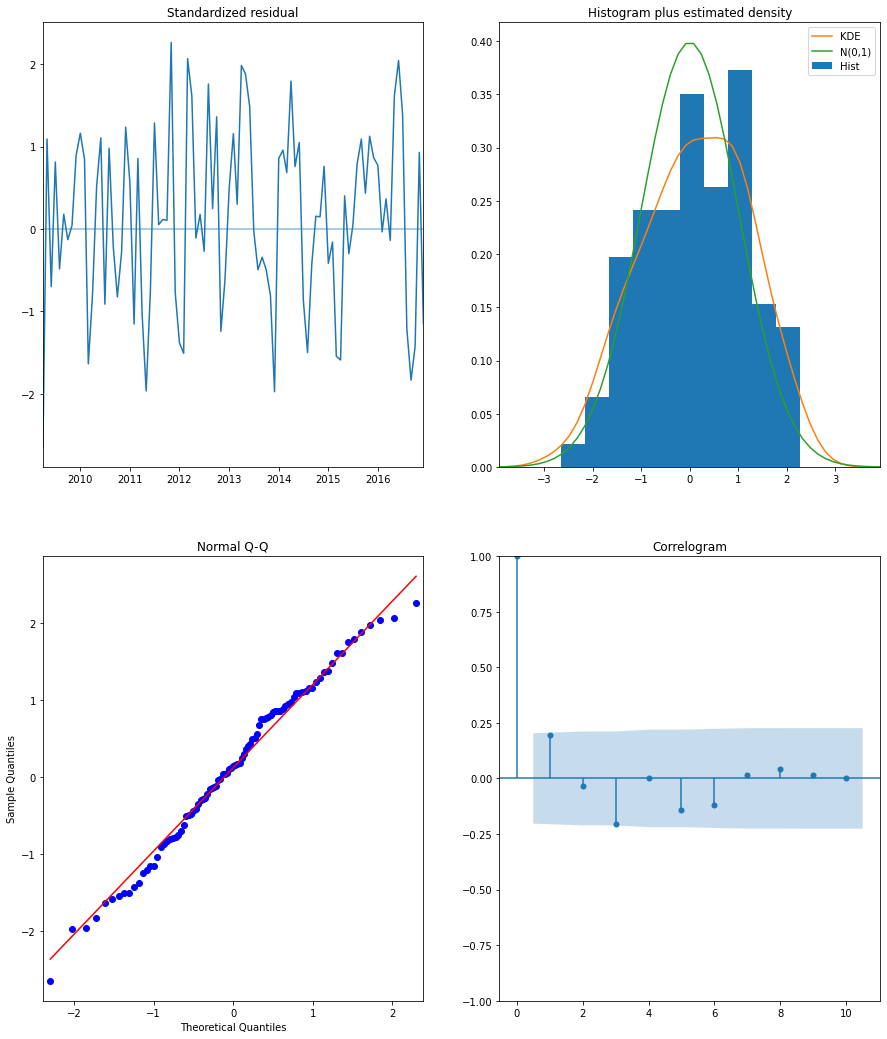

In [43]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [79]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_conf = pred.conf_int()

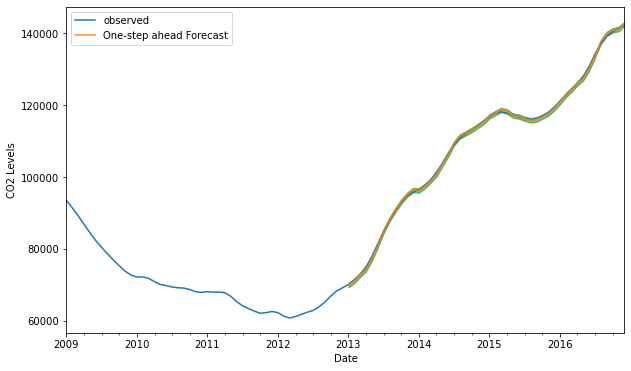

In [84]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 10, 6

# Plot observed values
ax = tmp.value['2009':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [81]:
# Get the real and predicted values
CO2_forecasted = pred.predicted_mean
CO2_truth = tmp.value['2013-01-01':]

# Compute the mean square error
mse = ((CO2_forecasted - CO2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 124000.45


In [82]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

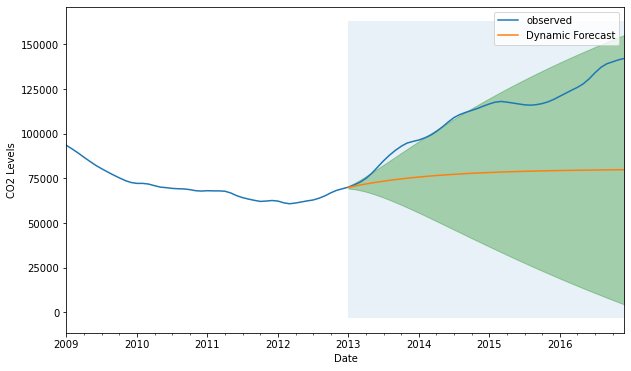

In [86]:
# Plot the dynamic forecast with confidence intervals.

ax = tmp.value['2009':].plot(label='observed', figsize=(10, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2013-01-01'), CO2_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

### ragne of 3, enf=True

In [104]:
# define p,d & q parameters
p = d = q = range(0,3)

# generate different combination of p,d,q
pdq = list(itertools.product(p,d,q))
# display(pdq)

In [105]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    try:
        tmp = get_data_by_city(df_train, 'Ferndale')
        mod = sm.tsa.statespace.SARIMAX(tmp.value,
                                        order=comb,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        output = mod.fit()
        ans.append([comb, output.aic])
#         print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
    except:
        continue

In [106]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq    (0, 2, 2)
aic      1322.62
Name: 8, dtype: object

In [107]:
# Plug the optimal parameter values into a new SARIMAX model
tmp = get_data_by_city(df_train, 'Ferndale')
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(tmp.value, 
                                        order=(0, 2, 2), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8512      0.101      8.454      0.000       0.654       1.049
ma.L2          0.2856      0.113      2.533      0.011       0.065       0.507
sigma2      1.109e+05   2.06e+04      5.383      0.000    7.05e+04    1.51e+05


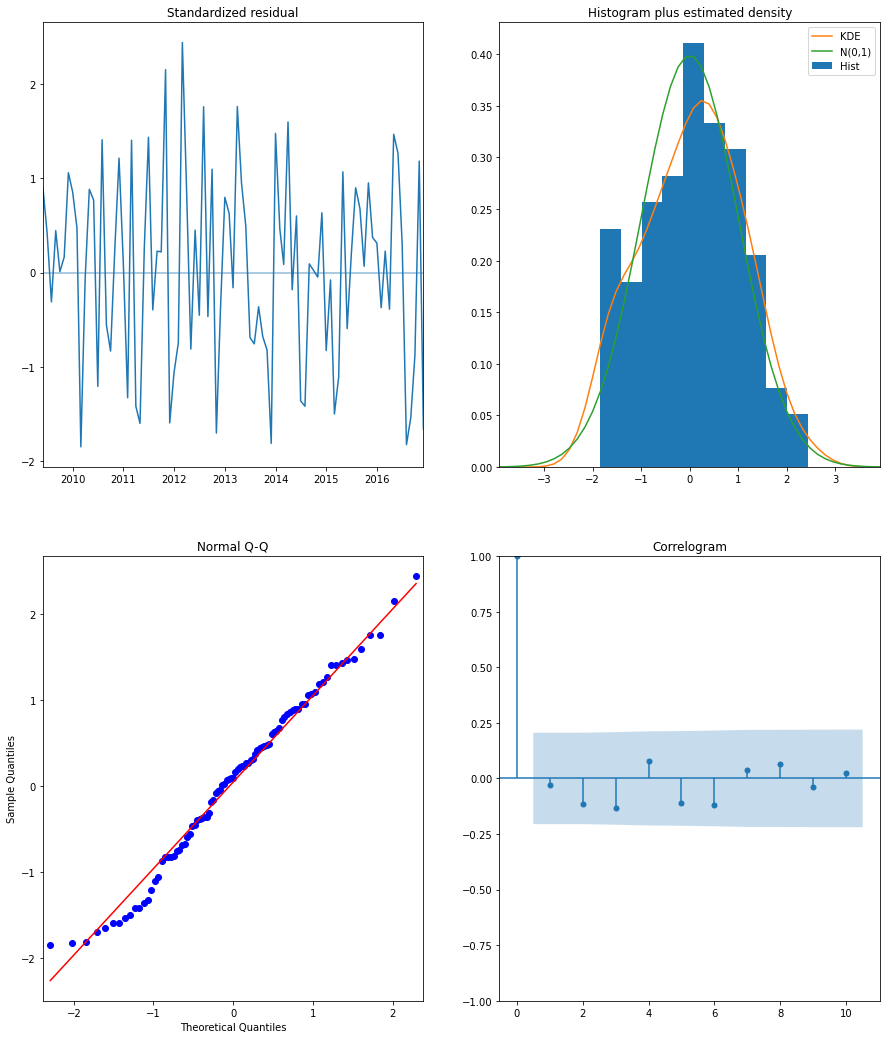

In [108]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [109]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_conf = pred.conf_int()

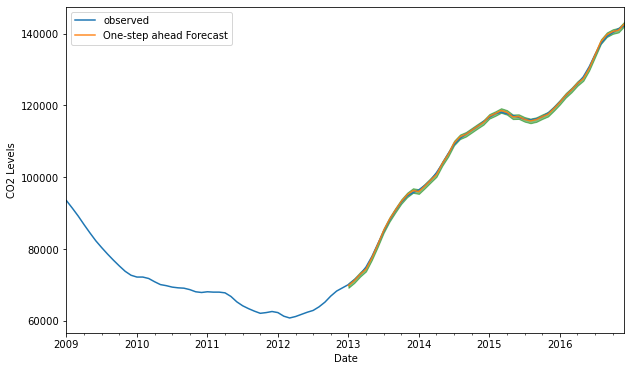

In [110]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 10, 6

# Plot observed values
ax = tmp.value['2009':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [111]:
# Get the real and predicted values
CO2_forecasted = pred.predicted_mean
CO2_truth = tmp.value['2013-01-01':]

# Compute the mean square error
mse = ((CO2_forecasted - CO2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 100200.44


In [112]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

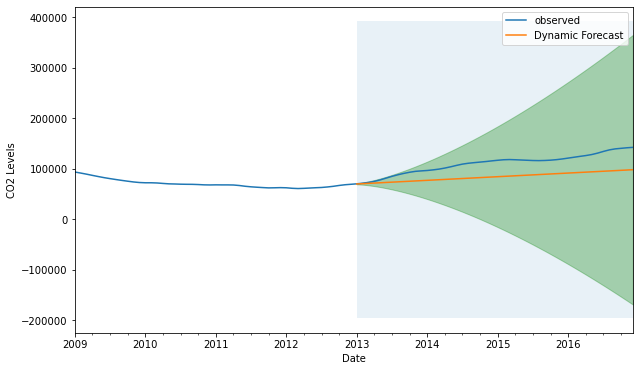

In [114]:
# Plot the dynamic forecast with confidence intervals.

ax = tmp.value['2009':].plot(label='observed', figsize=(10, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2013-01-01'), CO2_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

### based on ACF and PACF

In [37]:
# Plug the optimal parameter values into a new SARIMAX model
tmp = get_data_by_city(df_train, 'Ferndale')
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(tmp.value, 
                                        order=(2, 2, 1), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7574      0.199      3.801      0.000       0.367       1.148
ar.L2         -0.4342      0.131     -3.317      0.001      -0.691      -0.178
ma.L1         -0.0235      0.199     -0.118      0.906      -0.413       0.366
sigma2      1.119e+05   2.09e+04      5.355      0.000     7.1e+04    1.53e+05


D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



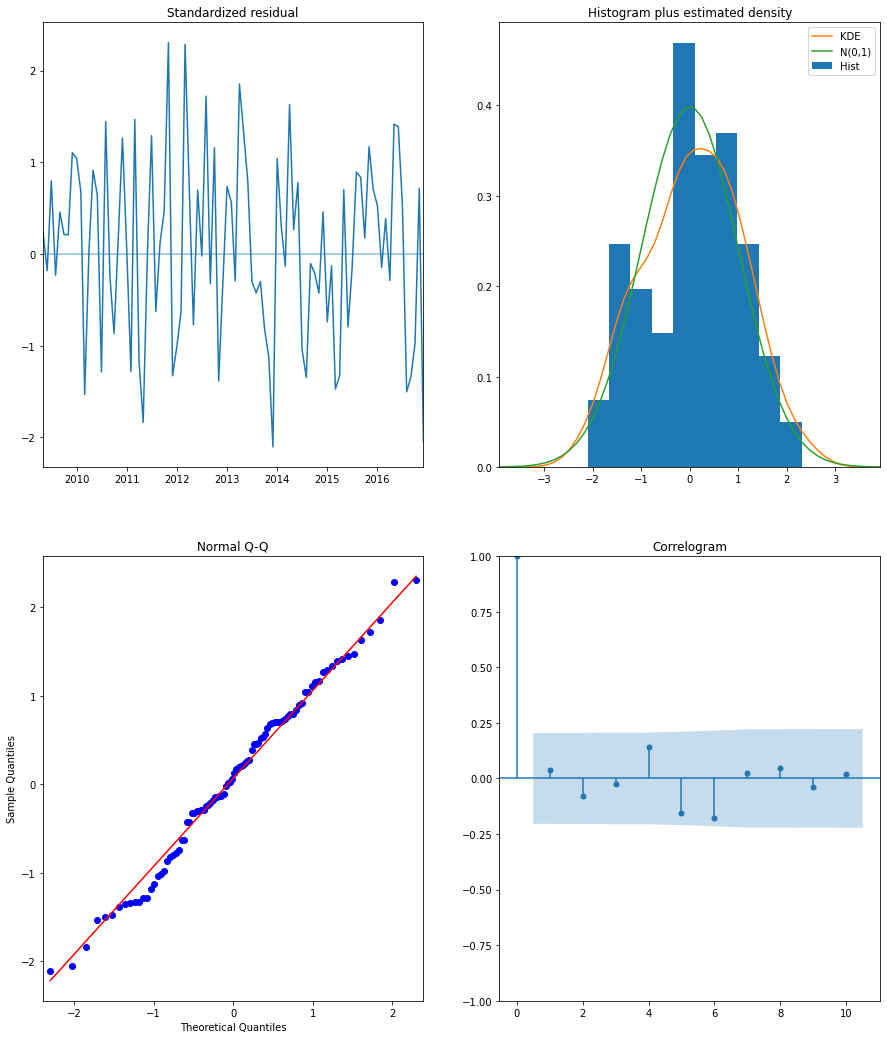

In [38]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [39]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_conf = pred.conf_int()

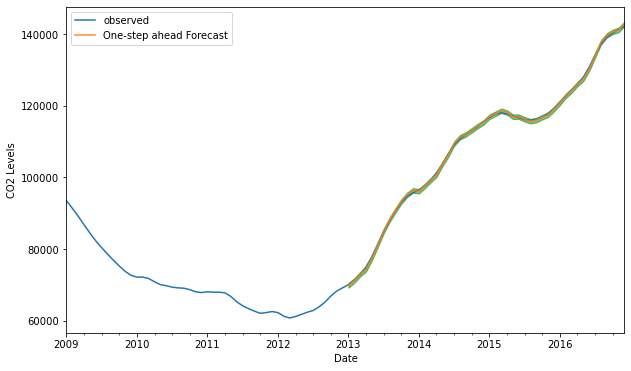

In [40]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 10, 6

# Plot observed values
ax = tmp.value['2009':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [41]:
# Get the real and predicted values
CO2_forecasted = pred.predicted_mean
CO2_truth = tmp.value['2013-01-01':]

# Compute the mean square error
mse = ((CO2_forecasted - CO2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 104626.85


In [42]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

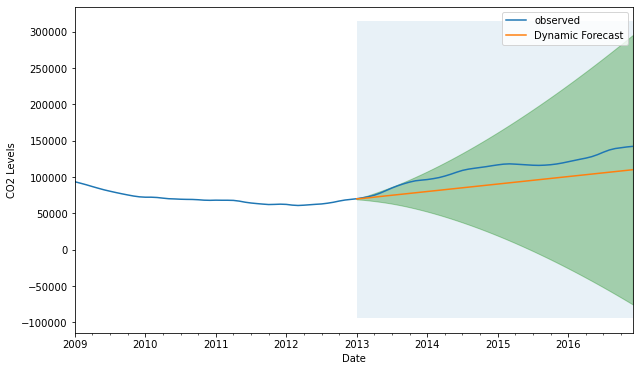

In [43]:
# Plot the dynamic forecast with confidence intervals.

ax = tmp.value['2009':].plot(label='observed', figsize=(10, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2013-01-01'), CO2_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

### Check Assumptions for Fitted ARIMA Model 

*** Coefficients Statistics, Ferndale ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, Ferndale ***


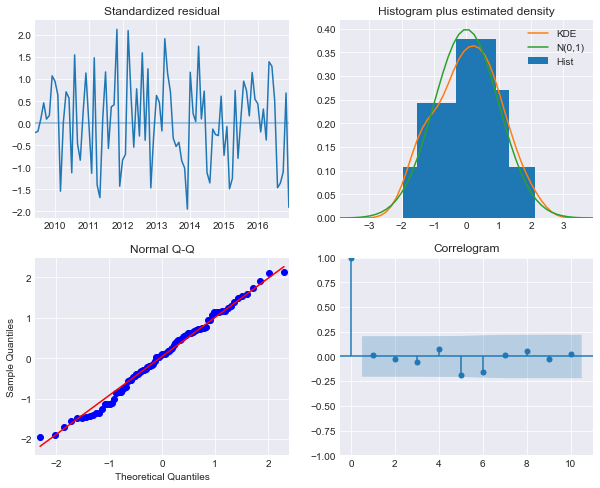

In [165]:
fit_arima_model(df_train, arima_params, 'Ferndale', enf_stationarity=False)

In [166]:
one_step_fc_arima(df_train, arima_params, 'Ferndale',
             pred_start_date='2013-01-01', enf_stationarity=False)

The mean square error of our forcast is 104406.87.
The root mean square error of our forcast is 323.12.


In [167]:
one_step_fc_arima(df_train, arima_params, 'Ferndale',
             pred_start_date='2013-01-01', enf_stationarity=False, dynamic=True)

The mean square error of our forcast is 475573170.62.
The root mean square error of our forcast is 21807.64.


In [14]:
# define p,d & q parameters
p = d = q = range(0,10)

# generate different combination of p,d,q
pdq = list(itertools.product(p,d,q))
display(pdq)

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 0, 9),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 9),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 2, 7),
 (0, 2, 8),
 (0, 2, 9),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 3, 5),
 (0, 3, 6),
 (0, 3, 7),
 (0, 3, 8),
 (0, 3, 9),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (0, 4, 5),
 (0, 4, 6),
 (0, 4, 7),
 (0, 4, 8),
 (0, 4, 9),
 (0, 5, 0),
 (0, 5, 1),
 (0, 5, 2),
 (0, 5, 3),
 (0, 5, 4),
 (0, 5, 5),
 (0, 5, 6),
 (0, 5, 7),
 (0, 5, 8),
 (0, 5, 9),
 (0, 6, 0),
 (0, 6, 1),
 (0, 6, 2),
 (0, 6, 3),
 (0, 6, 4),
 (0, 6, 5),
 (0, 6, 6),
 (0, 6, 7),
 (0, 6, 8),
 (0, 6, 9),
 (0, 7, 0),
 (0, 7, 1),
 (0, 7, 2),
 (0, 7, 3),
 (0, 7, 4),
 (0, 7, 5),
 (0, 7, 6),
 (0, 7, 7),
 (0, 7, 8),
 (0, 7, 9),
 (0, 8, 0),
 (0, 8, 1),
 (0, 8, 2),
 (0,

In [17]:
# get the best arima parameters based on lowest AIC score
arima_params = gen_arima_params(df_train, cities, pdq, enf_stationarity=True)
arima_params

city        pdq          AIC
30          Ferndale  (0, 3, 0)  1389.380510
1008       Brentwood  (0, 2, 0)  1624.663594
2940  East Riverdale  (9, 6, 6)  1640.755492
3196         Algonac  (2, 2, 2)  1539.406174
4230    North Street  (2, 6, 2)  1563.146336

In [21]:
# get the best arima parameters based on lowest AIC score
arima_params_2 = gen_arima_params(df_train, cities, pdq, enf_stationarity=True)
arima_params_2

city        pdq          AIC
30          Ferndale  (0, 3, 0)  1389.380510
1008       Brentwood  (0, 2, 0)  1624.663594
2940  East Riverdale  (9, 6, 6)  1640.755492
3196         Algonac  (2, 2, 2)  1539.406174
4230    North Street  (2, 6, 2)  1563.146336

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

*** Coefficients Statistics, Brentwood ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, Brentwood ***


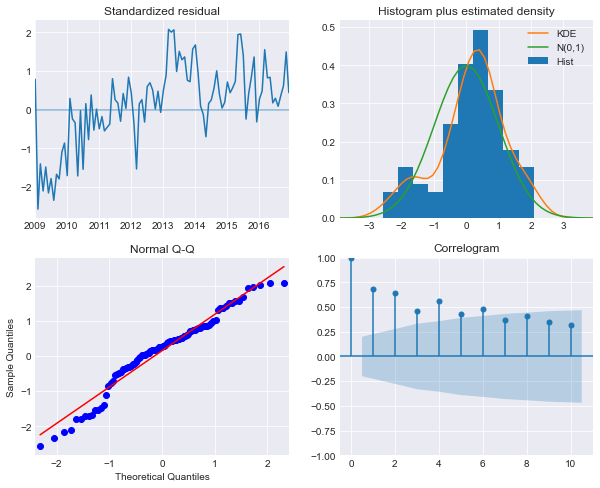

In [26]:
fit_arima_model(df_train, arima_params, 'Brentwood', enf_stationarity=True)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

*** Coefficients Statistics, East Riverdale ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, East Riverdale ***


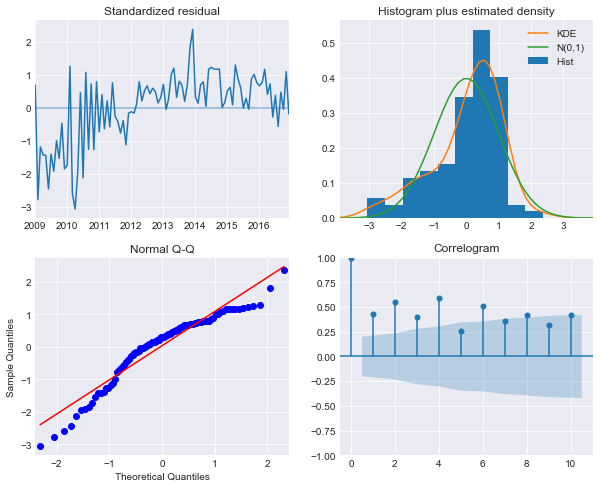

In [27]:
fit_arima_model(df_train, arima_params, 'East Riverdale', enf_stationarity=True)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

*** Coefficients Statistics, Algonac ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, Algonac ***


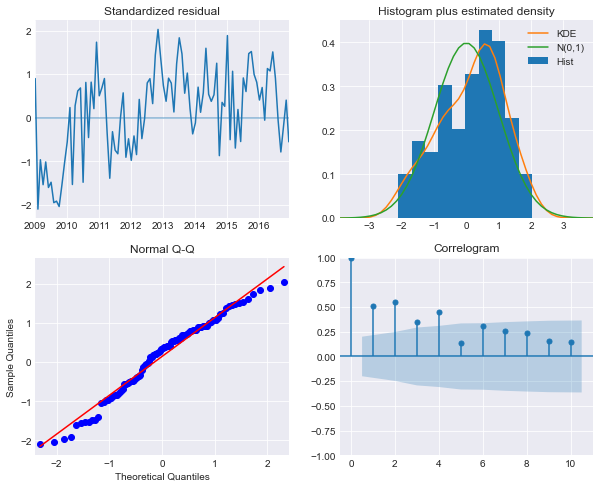

In [28]:
fit_arima_model(df_train, arima_params, 'Algonac', enf_stationarity=True)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

*** Coefficients Statistics, North Street ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, North Street ***


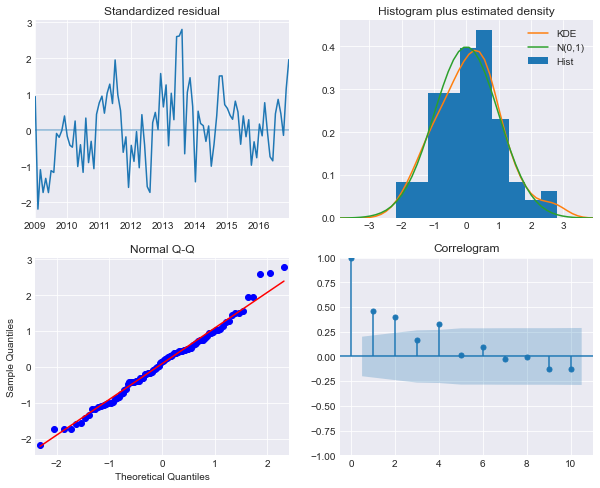

In [29]:
fit_arima_model(df_train, arima_params, 'North Street', enf_stationarity=True)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

### One-Step Ahead Forecasting on Training Data Set

In [30]:
one_step_fc_arima(df_train, arima_params, 'Ferndale',
             pred_start_date='2013-01-01', enf_stationarity=True)

The mean square error of our forcast is 910339.09.
The root mean square error of our forcast is 954.12.


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

In [31]:
one_step_fc_arima(df_train, arima_params, 'Brentwood',
             pred_start_date='2013-01-01', enf_stationarity=True)

The mean square error of our forcast is 3629920.71.
The root mean square error of our forcast is 1905.24.


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

In [32]:
one_step_fc_arima(df_train, arima_params, 'East Riverdale',
             pred_start_date='2013-01-01', enf_stationarity=True)

The mean square error of our forcast is 2286210.29.
The root mean square error of our forcast is 1512.02.


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

In [33]:
one_step_fc_arima(df_train, arima_params, 'Algonac',
             pred_start_date='2013-01-01', enf_stationarity=True)

The mean square error of our forcast is 849613.09.
The root mean square error of our forcast is 921.74.


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

In [34]:
one_step_fc_arima(df_train, arima_params, 'North Street',
             pred_start_date='2013-01-01', enf_stationarity=True)

The mean square error of our forcast is 1048722.71.
The root mean square error of our forcast is 1024.07.


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

### One-Step Ahead Forecasting on Validating Data Set

In [35]:
one_step_fc_arima(df_val, arima_params, 'Ferndale',
             pred_start_date='2017-02-01', enf_stationarity=True)

The mean square error of our forcast is 728072.44.
The root mean square error of our forcast is 853.27.


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

In [36]:
one_step_fc_arima(df_val, arima_params, 'Brentwood',
             pred_start_date='2017-02-01', enf_stationarity=True)

The mean square error of our forcast is 1171179.58.
The root mean square error of our forcast is 1082.21.


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

In [37]:
one_step_fc_arima(df_val, arima_params, 'East Riverdale',
             pred_start_date='2017-02-01', enf_stationarity=True)

The mean square error of our forcast is 2364786.86.
The root mean square error of our forcast is 1537.79.


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

In [38]:
one_step_fc_arima(df_val, arima_params, 'Algonac',
             pred_start_date='2017-02-01', enf_stationarity=True)

The mean square error of our forcast is 3143123.83.
The root mean square error of our forcast is 1772.89.


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

In [39]:
one_step_fc_arima(df_val, arima_params, 'North Street',
             pred_start_date='2017-02-01', enf_stationarity=True)

The mean square error of our forcast is 3007302.41.
The root mean square error of our forcast is 1734.16.


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li></li>
    </ul>
</div>

In [40]:
one_step_fc_arima(df_val, arima_params, 'Ferndale', pred_start_date='2017-02-01',
                  enf_stationarity=True, dynamic=True)

The mean square error of our forcast is 148183645.99.
The root mean square error of our forcast is 12173.07.


In [41]:
one_step_fc_arima(df_val, arima_params, 'Brentwood', pred_start_date='2017-02-01',
                  enf_stationarity=True, dynamic=True)

The mean square error of our forcast is 212998456.11.
The root mean square error of our forcast is 14594.47.


In [42]:
one_step_fc_arima(df_val, arima_params, 'East Riverdale', pred_start_date='2017-02-01',
                  enf_stationarity=True, dynamic=True)

The mean square error of our forcast is 364185939.48.
The root mean square error of our forcast is 19083.66.


In [43]:
one_step_fc_arima(df_val, arima_params, 'Algonac', pred_start_date='2017-02-01',
                  enf_stationarity=True, dynamic=True)

The mean square error of our forcast is 132339376.14.
The root mean square error of our forcast is 11503.89.


In [44]:
one_step_fc_arima(df_val, arima_params, 'North Street', pred_start_date='2017-02-01',
                  enf_stationarity=True, dynamic=True)

The mean square error of our forcast is 546109997.74.
The root mean square error of our forcast is 23369.0.


### One-Step Dynamic Forcast

In [45]:
one_step_fc_arima(df_val, arima_params, 'North Street', pred_start_date='2017-02-01',
                  enf_stationarity=True, dynamic=True)

The mean square error of our forcast is 546109997.74.
The root mean square error of our forcast is 23369.0.


In [46]:
output = fit_arima_model(df_train,arima_params, 'Ferndale', enf_stationarity=True,
                       summ=False,plot=False,model_out=True)

In [47]:
pred = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
prediction = pred.predicted_mean
prediction

2013-01-01     69615.616794
2013-02-01     70568.339449
2013-03-01     72208.754753
2013-04-01     73571.287051
2013-05-01     76394.648855
2013-06-01     79370.104679
2013-07-01     83385.153579
2013-08-01     86379.845182
2013-09-01     89583.492566
2013-10-01     91788.951462
2013-11-01     94181.998211
2013-12-01     95399.198861
2014-01-01     95987.380395
2014-02-01     96995.738335
2014-03-01     98384.319516
2014-04-01     99994.018308
2014-05-01    102576.676378
2014-06-01    104995.384279
2014-07-01    108170.938401
2014-08-01    110005.610411
2014-09-01    111572.973443
2014-10-01    112410.998395
2014-11-01    113769.222719
2014-12-01    114614.677350
2015-01-01    116362.879653
2015-02-01    117022.249985
2015-03-01    118358.251107
2015-04-01    117834.816969
2015-05-01    117556.616808
2015-06-01    116837.718373
2015-07-01    116553.794968
2015-08-01    115840.475094
2015-09-01    116147.340064
2015-10-01    116440.558109
2015-11-01    117343.569095
2015-12-01    118439

In [48]:
d_pred = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=True, full_results=True)
d_prediction = d_pred.predicted_mean
d_prediction

2013-01-01    69615.616794
2013-02-01    69609.500952
2013-03-01    69603.385649
2013-04-01    69597.270882
2013-05-01    69591.156653
2013-06-01    69585.042960
2013-07-01    69578.929805
2013-08-01    69572.817187
2013-09-01    69566.705106
2013-10-01    69560.593562
2013-11-01    69554.482555
2013-12-01    69548.372084
2014-01-01    69542.262151
2014-02-01    69536.152754
2014-03-01    69530.043894
2014-04-01    69523.935570
2014-05-01    69517.827783
2014-06-01    69511.720533
2014-07-01    69505.613820
2014-08-01    69499.507642
2014-09-01    69493.402002
2014-10-01    69487.296897
2014-11-01    69481.192329
2014-12-01    69475.088297
2015-01-01    69468.984802
2015-02-01    69462.881843
2015-03-01    69456.779420
2015-04-01    69450.677533
2015-05-01    69444.576182
2015-06-01    69438.475367
2015-07-01    69432.375088
2015-08-01    69426.275345
2015-09-01    69420.176137
2015-10-01    69414.077466
2015-11-01    69407.979331
2015-12-01    69401.881731
2016-01-01    69395.784667
2

In [49]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-02-01'),
                                     dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [50]:
# # Plot the dynamic forecast with confidence intervals.



# ax = df['1990':].plot(label='observed', figsize=(20, 15))
# pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

# ax.fill_between(pred_dynamic_conf.index,
#                 pred_dynamic_conf.iloc[:, 0],
#                 pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

# ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), CO2_forecasted.index[-1], alpha=.1, zorder=-1)

# ax.set_xlabel('Date')
# ax.set_ylabel('CO2 Levels')

# plt.legend()
# plt.show()

## Model B

### Check Assumptions for Fitted SARIMA Model 

In [91]:
# gen arima model with range = 0,2
# define p,d & q parameters
p = d = q = range(0,2)

# generate different combination of p,d,q
pdq = list(itertools.product(p,d,q))


# generate different combination of P,D,Q
PDQ = [(x[0], x[1], x[2], 2) for x in pdq]
display(pdq, PDQ)

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

[(0, 0, 0, 2),
 (0, 0, 1, 2),
 (0, 1, 0, 2),
 (0, 1, 1, 2),
 (1, 0, 0, 2),
 (1, 0, 1, 2),
 (1, 1, 0, 2),
 (1, 1, 1, 2)]

In [54]:
sarima_params = gen_sarima_params(df_train, cities, pdq, PDQ, enf_stationarity=False)

In [87]:
sarima_params

city        pdq           PDQ          AIC
63         Ferndale  (1, 1, 1)  (1, 1, 1, 2)  1315.446104
121       Brentwood  (1, 1, 1)  (0, 0, 1, 2)  1547.168855
189  East Riverdale  (1, 1, 1)  (1, 0, 1, 2)  1592.593390
255         Algonac  (1, 1, 1)  (1, 1, 1, 2)  1460.600557
313    North Street  (1, 1, 1)  (0, 0, 1, 2)  1479.238589

*** Coefficients Statistics, Ferndale ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, Ferndale ***


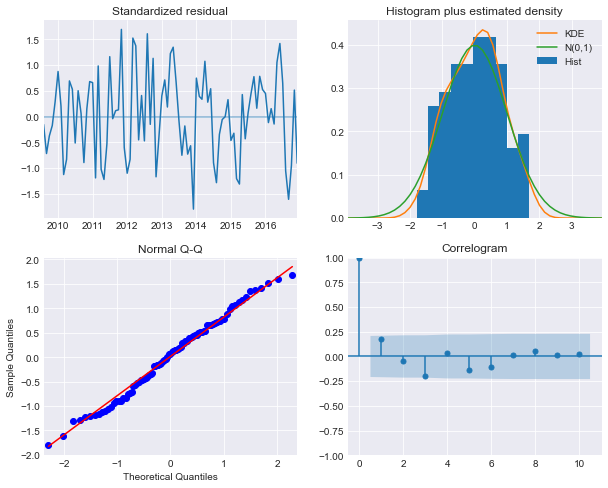

In [55]:
fit_sarima_model(df_train, sarima_params,'Ferndale', enf_stationarity=False)

*** Coefficients Statistics, Brentwood ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, Brentwood ***


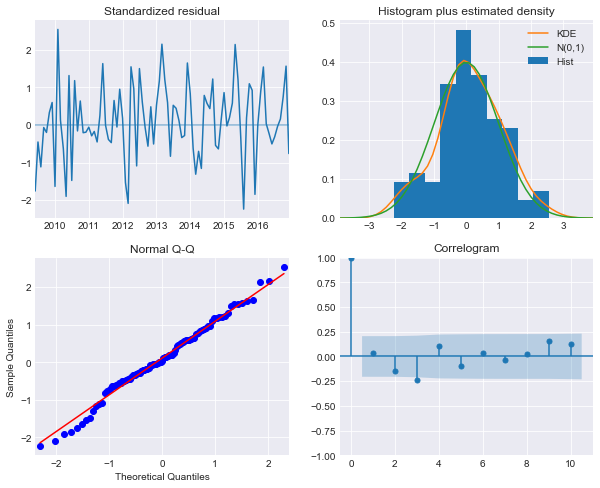

In [56]:
fit_sarima_model(df_train, sarima_params,'Brentwood', enf_stationarity=False)

*** Coefficients Statistics, East Riverdale ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, East Riverdale ***


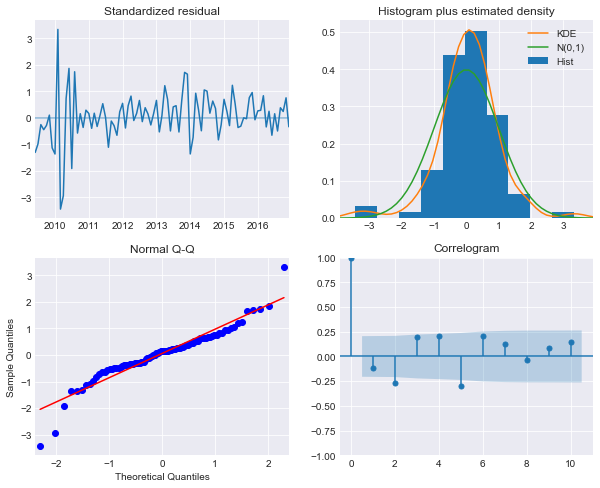

In [57]:
fit_sarima_model(df_train, sarima_params,'East Riverdale', enf_stationarity=False)

*** Coefficients Statistics, Algonac ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, Algonac ***


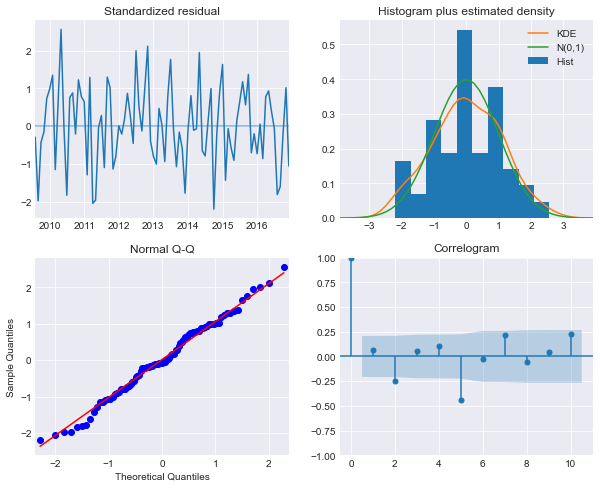

In [58]:
fit_sarima_model(df_train, sarima_params,'Algonac', enf_stationarity=False)

*** Coefficients Statistics, North Street ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, North Street ***


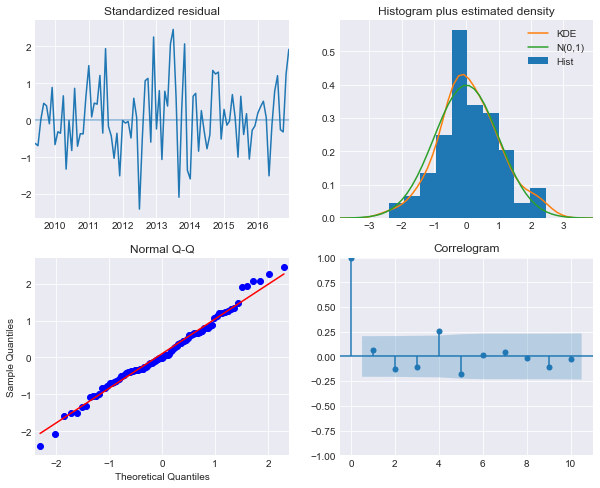

In [59]:
fit_sarima_model(df_train, sarima_params,'North Street', enf_stationarity=False)

In [61]:
one_step_fc_sarima(df_train, sarima_params, 'Ferndale',
                   pred_start_date='2013-01-01', enf_stationarity=True)

The mean square error of our forcast is 647650.92.
The root mean square error of our forcast is 804.77.


In [62]:
one_step_fc_sarima(df_train, sarima_params, 'Brentwood',
                   pred_start_date='2013-01-01', enf_stationarity=True)

The mean square error of our forcast is 11244101.4.
The root mean square error of our forcast is 3353.22.


In [63]:
one_step_fc_sarima(df_train, sarima_params, 'East Riverdale',
                   pred_start_date='2013-01-01', enf_stationarity=True)

The mean square error of our forcast is 9383227.98.
The root mean square error of our forcast is 3063.21.


In [64]:
one_step_fc_sarima(df_train, sarima_params, 'Algonac',
                   pred_start_date='2013-01-01', enf_stationarity=True)

The mean square error of our forcast is 1926731.28.
The root mean square error of our forcast is 1388.07.


In [65]:
one_step_fc_sarima(df_train, sarima_params, 'North Street',
                   pred_start_date='2013-01-01', enf_stationarity=True)

The mean square error of our forcast is 3056881.02.
The root mean square error of our forcast is 1748.39.


In [78]:
one_step_fc_sarima(df_train, sarima_params, 'Ferndale',
                   pred_start_date='2013-01-01', enf_stationarity=True, dynamic=True)

The mean square error of our forcast is 198452099.21.
The root mean square error of our forcast is 14087.3.


In [87]:
sarima_params

city        pdq           PDQ          AIC
347         Ferndale  (1, 2, 1)  (0, 1, 2, 2)  1266.162176
854        Brentwood  (2, 1, 1)  (0, 1, 2, 2)  1471.519734
1175  East Riverdale  (1, 1, 1)  (1, 1, 2, 2)  1503.015389
1670         Algonac  (1, 2, 1)  (0, 1, 2, 2)  1411.916078
1940    North Street  (0, 2, 1)  (2, 1, 2, 2)  1412.950860

*** Coefficients Statistics, Ferndale ***


<class 'statsmodels.iolib.table.SimpleTable'>

*** SARIMAX Diagnostics Plot, Ferndale ***


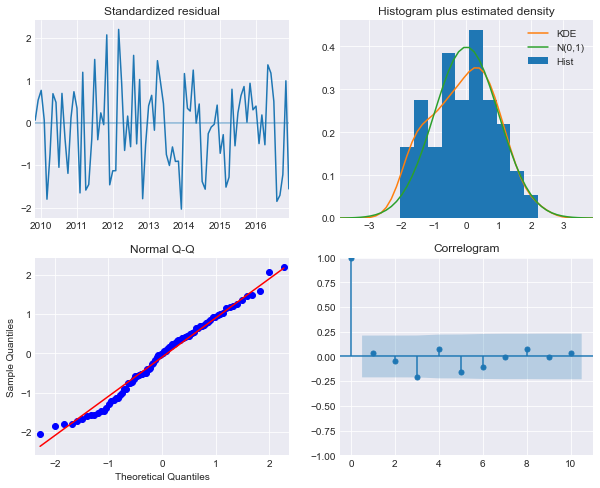

In [88]:
fit_sarima_model(df_train, sarima_params,'Ferndale', enf_stationarity=False)

In [89]:
one_step_fc_sarima(df_train, sarima_params, 'Ferndale',
                   pred_start_date='2013-01-01', enf_stationarity=True)

The mean square error of our forcast is 333943.08.
The root mean square error of our forcast is 577.88.


In [90]:
one_step_fc_sarima(df_train, sarima_params, 'Ferndale',
                   pred_start_date='2013-01-01', enf_stationarity=True, dynamic=True)

The mean square error of our forcast is 51671856100.41.
The root mean square error of our forcast is 227314.44.


In [86]:
#                    lab codes

In [123]:
# Plug the optimal parameter values into a new SARIMAX model
tmp = get_data_by_city(df_train, 'Ferndale')
ARIMA_MODEL = sm.tsa.SARIMAX(tmp, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 2), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7419      0.241      3.073      0.002       0.269       1.215
ma.L1          0.7693      0.257      2.990      0.003       0.265       1.274
ar.S.L2        0.0869      0.037      2.327      0.020       0.014       0.160
ma.S.L2       -0.6957      0.343     -2.026      0.043      -1.369      -0.023
sigma2      1.929e+05   4.98e+04      3.870      0.000    9.52e+04    2.91e+05


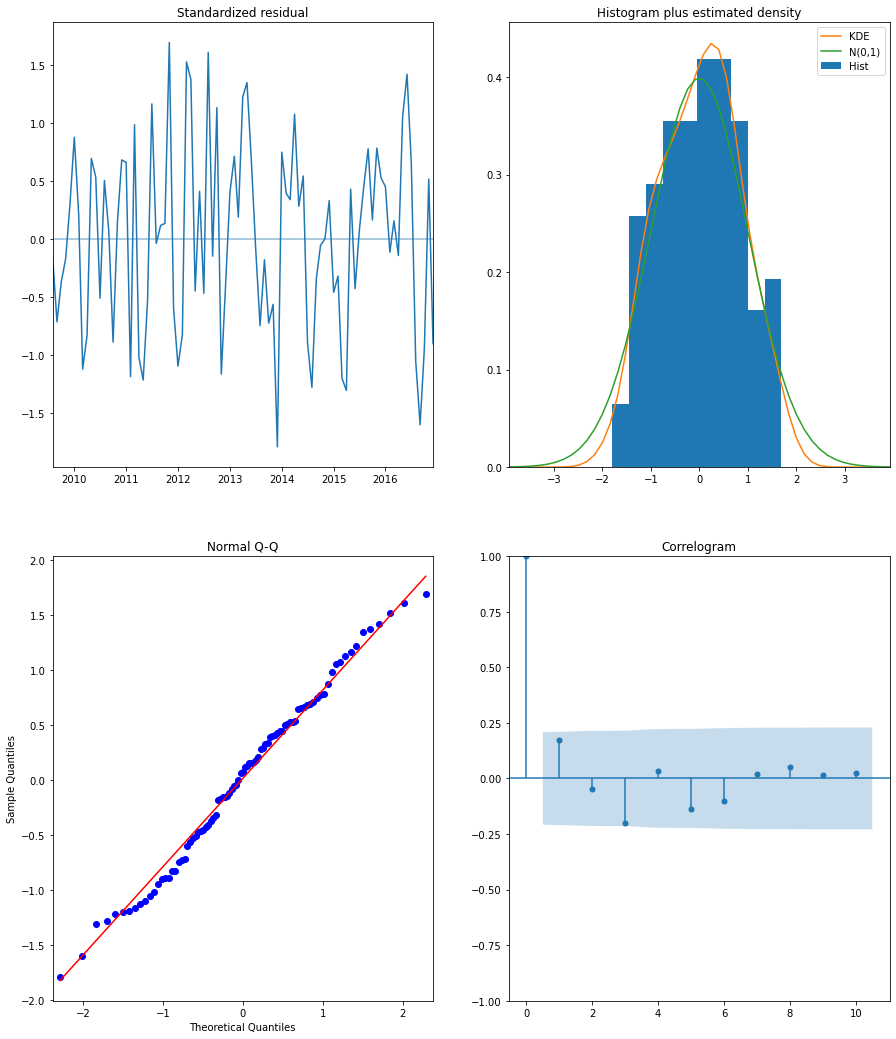

In [124]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [125]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_conf = pred.conf_int()

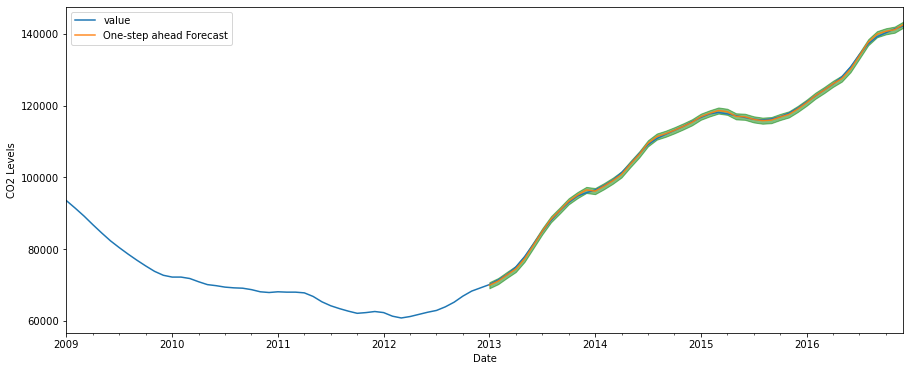

In [126]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
tmp = get_data_by_city(df_train, 'Ferndale')
ax = tmp['2009':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [127]:
# Get the real and predicted values
CO2_forecasted = pred.predicted_mean
CO2_truth = tmp['2013-01-01':].values.ravel()

# Compute the mean square error
mse = ((CO2_forecasted - CO2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 117209.63


In [128]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

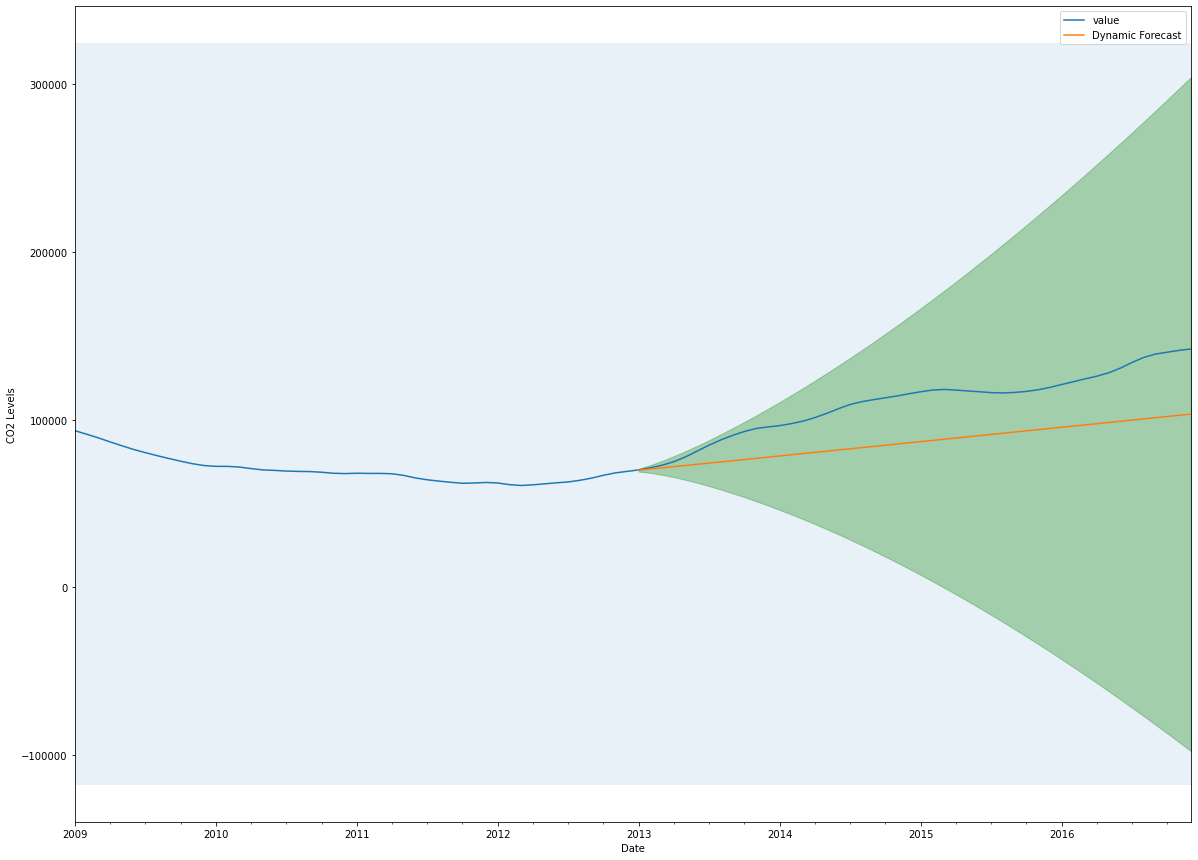

In [129]:
tmp = get_data_by_city(df_train, 'Ferndale')

ax = tmp['2009':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2009'), CO2_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [23]:
# gen arima model with range = 0,2
# define p,d & q parameters
p = d = q = range(0,2)

# generate different combination of p,d,q
pdq = list(itertools.product(p,d,q))
display(pdq)

# generate different combination of P,D,Q
PDQ = [(x[0], x[1], x[2], 2) for x in pdq]
display(PDQ)

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

[(0, 0, 0, 2),
 (0, 0, 1, 2),
 (0, 1, 0, 2),
 (0, 1, 1, 2),
 (1, 0, 0, 2),
 (1, 0, 1, 2),
 (1, 1, 0, 2),
 (1, 1, 1, 2)]

In [33]:
sarima_params = gen_sarima_params(df_train, cities, pdq, PDQ, enf_stationarity=False)

sarima_params

city        pdq           PDQ          AIC
63         Ferndale  (1, 1, 1)  (1, 1, 1, 2)  1315.446104
121       Brentwood  (1, 1, 1)  (0, 0, 1, 2)  1547.168855
189  East Riverdale  (1, 1, 1)  (1, 0, 1, 2)  1592.593390
255         Algonac  (1, 1, 1)  (1, 1, 1, 2)  1460.600557
313    North Street  (1, 1, 1)  (0, 0, 1, 2)  1479.238589

In [39]:
# Plug the optimal parameter values into a new SARIMAX model
tmp = get_data_by_city(df_train, 'Ferndale')
ARIMA_MODEL = sm.tsa.SARIMAX(tmp, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 2), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7419      0.241      3.073      0.002       0.269       1.215
ma.L1          0.7693      0.257      2.990      0.003       0.265       1.274
ar.S.L2        0.0869      0.037      2.327      0.020       0.014       0.160
ma.S.L2       -0.6957      0.343     -2.026      0.043      -1.369      -0.023
sigma2      1.929e+05   4.98e+04      3.870      0.000    9.52e+04    2.91e+05


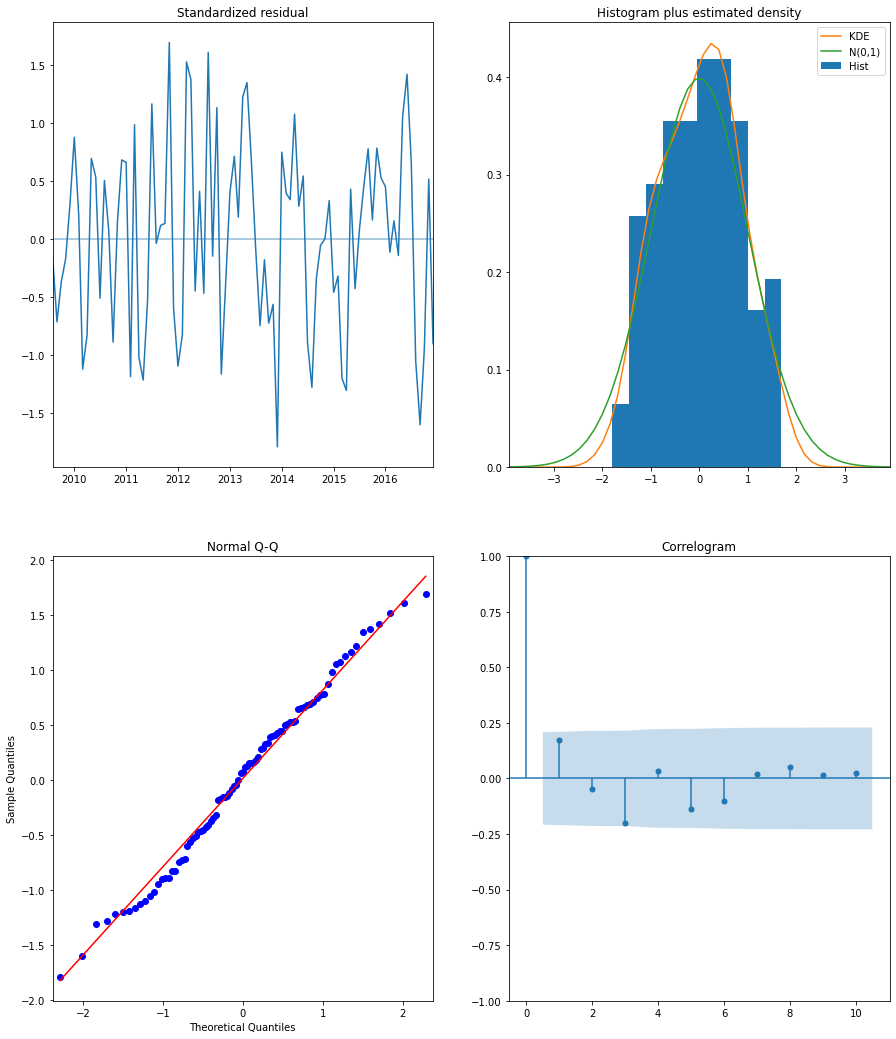

In [40]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [41]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_conf = pred.conf_int()

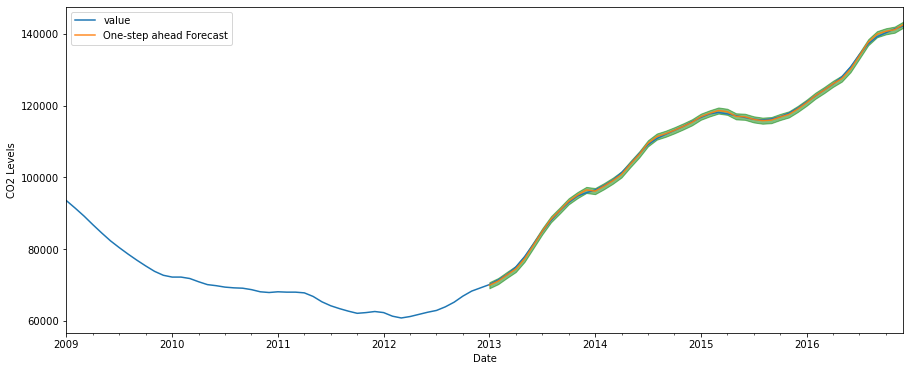

In [42]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
tmp = get_data_by_city(df_train, 'Ferndale')
ax = tmp['2009':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [43]:
# Get the real and predicted values
CO2_forecasted = pred.predicted_mean
CO2_truth = tmp['2013-01-01':].values.ravel()

# Compute the mean square error
mse = ((CO2_forecasted - CO2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 117209.63


In [44]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

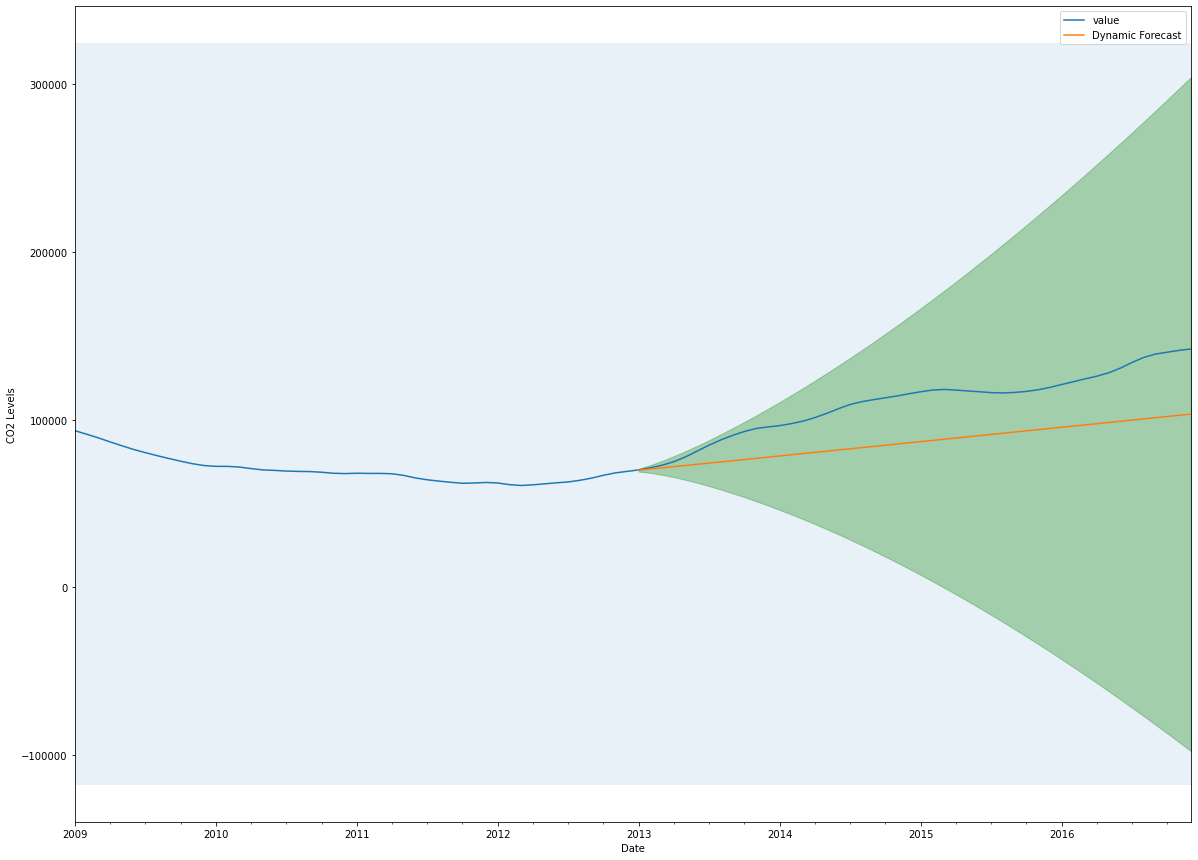

In [45]:
tmp = get_data_by_city(df_train, 'Ferndale')

ax = tmp['2009':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2009'), CO2_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [46]:
# gen arima model with range = 0,2
# define p,d & q parameters
p = d = q = range(0,3)

# generate different combination of p,d,q
pdq = list(itertools.product(p,d,q))
# display(pdq)

# generate different combination of P,D,Q
PDQ = [(x[0], x[1], x[2], 2) for x in pdq]
# display(PDQ)

In [47]:
sarima_params = gen_sarima_params(df_train, cities, pdq, PDQ, enf_stationarity=False)
sarima_params

city        pdq           PDQ          AIC
347         Ferndale  (1, 2, 1)  (0, 1, 2, 2)  1266.162176
854        Brentwood  (2, 1, 1)  (0, 1, 2, 2)  1471.519734
1175  East Riverdale  (1, 1, 1)  (1, 1, 2, 2)  1503.015389
1670         Algonac  (1, 2, 1)  (0, 1, 2, 2)  1411.916078
1940    North Street  (0, 2, 1)  (2, 1, 2, 2)  1412.950860

In [61]:
# Plug the optimal parameter values into a new SARIMAX model
tmp = get_data_by_city(df_train, 'Ferndale')
ARIMA_MODEL = sm.tsa.SARIMAX(tmp, 
                                        order=(1, 2, 1), 
                                        seasonal_order=(0, 1, 2, 2), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3008      0.122      2.460      0.014       0.061       0.540
ma.L1          0.4429      0.110      4.013      0.000       0.227       0.659
ma.S.L2       -1.0983      0.245     -4.476      0.000      -1.579      -0.617
ma.S.L4        0.0982      0.140      0.700      0.484      -0.177       0.373
sigma2      1.208e+05   2.12e-06    5.7e+10      0.000    1.21e+05    1.21e+05


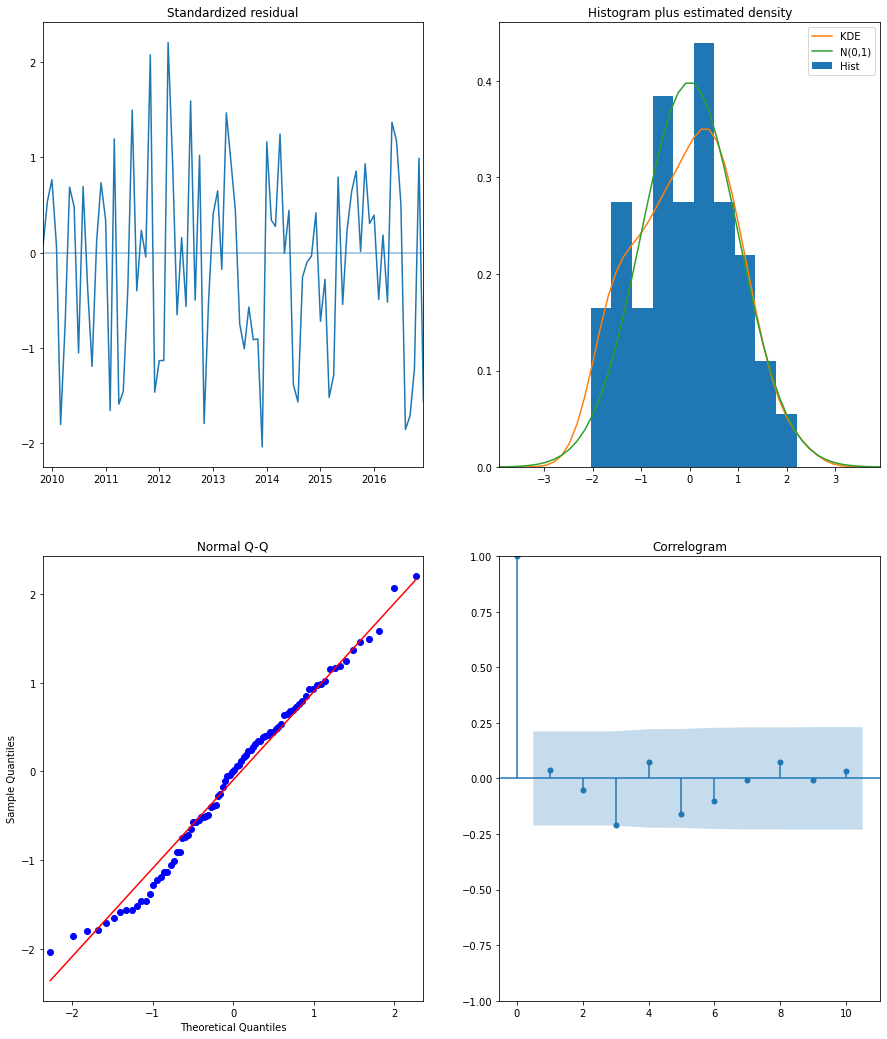

In [67]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [62]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_conf = pred.conf_int()

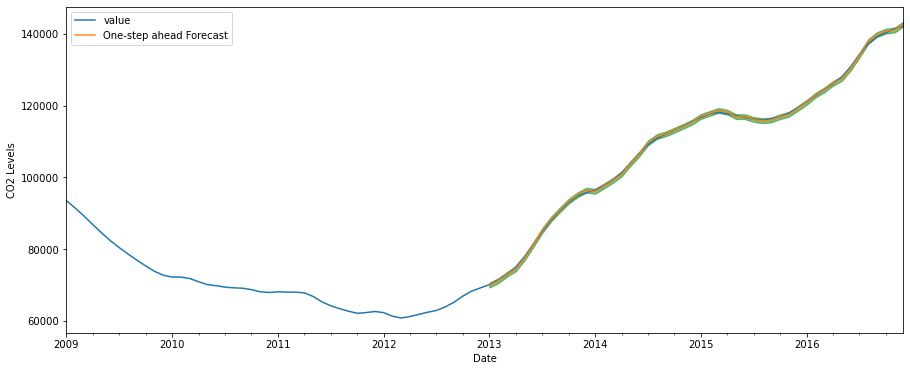

In [70]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = tmp['2009':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [71]:
# Get the real and predicted values
CO2_forecasted = pred.predicted_mean
CO2_truth = tmp['2013-01-01':].values.ravel()

# Compute the mean square error
mse = ((CO2_forecasted - CO2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 110547.26


In [84]:
CO2_forecasted

2013-01-01     69957.243871
2013-02-01     70778.203796
2013-03-01     71666.570496
2013-04-01     72638.245272
2013-05-01     73675.620461
2013-06-01     74795.790511
2013-07-01     75981.506616
2013-08-01     77249.971156
2013-09-01     78583.967790
2013-10-01     80000.708659
2013-11-01     81482.980358
2013-12-01     83047.995913
2014-01-01     84678.542183
2014-02-01     86391.832275
2014-03-01     88170.653071
2014-04-01     90032.217687
2014-05-01     91959.313006
2014-06-01     93969.152144
2014-07-01     96044.521985
2014-08-01     98202.635645
2014-09-01    100426.280009
2014-10-01    102732.668191
2014-11-01    105104.587076
2014-12-01    107559.249781
2015-01-01    110079.443189
2015-02-01    112682.380415
2015-03-01    115350.848345
2015-04-01    118102.060094
2015-05-01    120918.802546
2015-06-01    123818.288817
2015-07-01    126783.305791
2015-08-01    129831.066584
2015-09-01    132944.358081
2015-10-01    136140.393396
2015-11-01    139401.959414
2015-12-01    142746

In [85]:
tmp['2013-01-01':]

value
time                
2013-01-01   70100.0
2013-02-01   71400.0
2013-03-01   72900.0
2013-04-01   75000.0
2013-05-01   77900.0
2013-06-01   81400.0
2013-07-01   84900.0
2013-08-01   88000.0
2013-09-01   90700.0
2013-10-01   93000.0
2013-11-01   94800.0
2013-12-01   95700.0
2014-01-01   96500.0
2014-02-01   97700.0
2014-03-01   99200.0
2014-04-01  101300.0
2014-05-01  103800.0
2014-06-01  106600.0
2014-07-01  109100.0
2014-08-01  110800.0
2014-09-01  112000.0
2014-10-01  113100.0
2014-11-01  114200.0
2014-12-01  115500.0
2015-01-01  116700.0
2015-02-01  117700.0
2015-03-01  118100.0
2015-04-01  117700.0
2015-05-01  117200.0
2015-06-01  116700.0
2015-07-01  116200.0
2015-08-01  116000.0
2015-09-01  116300.0
2015-10-01  116900.0
2015-11-01  117900.0
2015-12-01  119300.0
2016-01-01  121000.0
2016-02-01  122700.0
2016-03-01  124400.0
2016-04-01  126000.0
2016-05-01  128000.0
2016-06-01  130800.0
2016-07-01  134200.0
2016-08-01  137200.0
2016-09-01  139200.0
2016-10-01  140300.0
2016-11-01  141400.0
2016-12-01  142200.0

In [72]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [82]:
pred_dynamic_conf.tail(10)

lower value    upper value
2016-03-01  -76059.661734  382473.280164
2016-04-01  -82504.313123  396199.649316
2016-05-01  -89080.704396  410188.819759
2016-06-01  -95770.021882  424456.404054
2016-07-01 -102590.494638  438986.205024
2016-08-01 -109523.386120  453793.912358
2016-09-01 -116586.913841  468863.317338
2016-10-01 -123762.410522  484210.178915
2016-11-01 -131068.080675  499818.275372
2016-12-01 -138485.319587  515703.428224

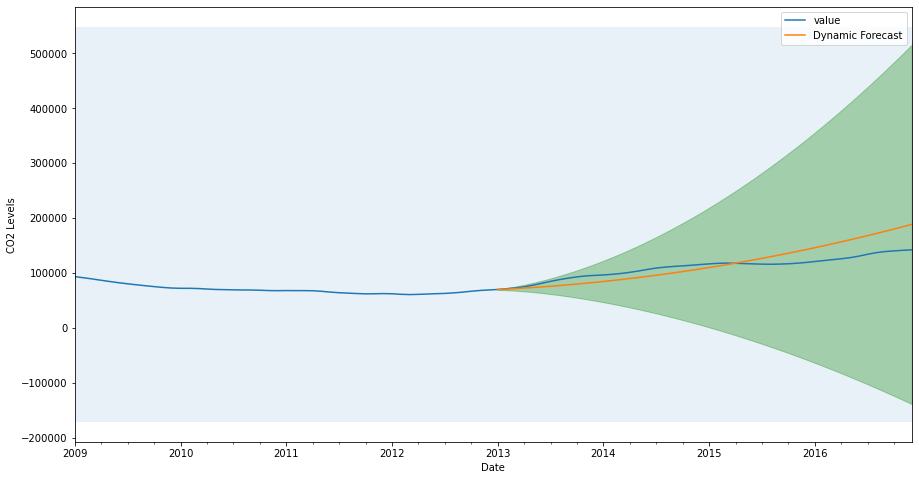

In [66]:
tmp = get_data_by_city(df_train, 'Ferndale')

ax = tmp['2009':].plot(label='observed', figsize=(15, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2009'), CO2_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()


In [76]:
# Extract the predicted and true values of our time series
CO2_forecasted = pred_dynamic.predicted_mean
CO2_truth = tmp['2013-01-01':].values.ravel()

# Compute the mean square error
mse = ((CO2_forecasted - CO2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 400294385.96


In [77]:
CO2_forecasted

2013-01-01     69957.243871
2013-02-01     70778.203796
2013-03-01     71666.570496
2013-04-01     72638.245272
2013-05-01     73675.620461
2013-06-01     74795.790511
2013-07-01     75981.506616
2013-08-01     77249.971156
2013-09-01     78583.967790
2013-10-01     80000.708659
2013-11-01     81482.980358
2013-12-01     83047.995913
2014-01-01     84678.542183
2014-02-01     86391.832275
2014-03-01     88170.653071
2014-04-01     90032.217687
2014-05-01     91959.313006
2014-06-01     93969.152144
2014-07-01     96044.521985
2014-08-01     98202.635645
2014-09-01    100426.280009
2014-10-01    102732.668191
2014-11-01    105104.587076
2014-12-01    107559.249781
2015-01-01    110079.443189
2015-02-01    112682.380415
2015-03-01    115350.848345
2015-04-01    118102.060094
2015-05-01    120918.802546
2015-06-01    123818.288817
2015-07-01    126783.305791
2015-08-01    129831.066584
2015-09-01    132944.358081
2015-10-01    136140.393396
2015-11-01    139401.959414
2015-12-01    142746

In [78]:
CO2_truth

array([ 70100.,  71400.,  72900.,  75000.,  77900.,  81400.,  84900.,
        88000.,  90700.,  93000.,  94800.,  95700.,  96500.,  97700.,
        99200., 101300., 103800., 106600., 109100., 110800., 112000.,
       113100., 114200., 115500., 116700., 117700., 118100., 117700.,
       117200., 116700., 116200., 116000., 116300., 116900., 117900.,
       119300., 121000., 122700., 124400., 126000., 128000., 130800.,
       134200., 137200., 139200., 140300., 141400., 142200.])

In [79]:
tmp

value
time                
2009-01-01   93500.0
2009-02-01   91400.0
2009-03-01   89200.0
2009-04-01   86800.0
2009-05-01   84500.0
...              ...
2016-08-01  137200.0
2016-09-01  139200.0
2016-10-01  140300.0
2016-11-01  141400.0
2016-12-01  142200.0

[96 rows x 1 columns]

In [80]:
tmp['2013':]

value
time                
2013-01-01   70100.0
2013-02-01   71400.0
2013-03-01   72900.0
2013-04-01   75000.0
2013-05-01   77900.0
2013-06-01   81400.0
2013-07-01   84900.0
2013-08-01   88000.0
2013-09-01   90700.0
2013-10-01   93000.0
2013-11-01   94800.0
2013-12-01   95700.0
2014-01-01   96500.0
2014-02-01   97700.0
2014-03-01   99200.0
2014-04-01  101300.0
2014-05-01  103800.0
2014-06-01  106600.0
2014-07-01  109100.0
2014-08-01  110800.0
2014-09-01  112000.0
2014-10-01  113100.0
2014-11-01  114200.0
2014-12-01  115500.0
2015-01-01  116700.0
2015-02-01  117700.0
2015-03-01  118100.0
2015-04-01  117700.0
2015-05-01  117200.0
2015-06-01  116700.0
2015-07-01  116200.0
2015-08-01  116000.0
2015-09-01  116300.0
2015-10-01  116900.0
2015-11-01  117900.0
2015-12-01  119300.0
2016-01-01  121000.0
2016-02-01  122700.0
2016-03-01  124400.0
2016-04-01  126000.0
2016-05-01  128000.0
2016-06-01  130800.0
2016-07-01  134200.0
2016-08-01  137200.0
2016-09-01  139200.0
2016-10-01  140300.0
2016-11-01  141400.0
2016-12-01  142200.0